# PCA, Nearest Neighbors, Classification and Clustering

This tour details Principal Component Analysis, supervised classification using nearest neighbours and unsupervised classification using K-means.

In [569]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(34)

We load the IRIS dataset, which consists of 50 samples from three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters.

In [2]:
from sklearn import datasets

iris = datasets.load_iris()

In [3]:
# Instanciate the data and the classes
X = iris.data   # (150, 4) matrix
y = iris.target # (150,) vector of labels

The data is ordered by class:

In [4]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

So we randomly permute it:

In [5]:
permutation = np.random.permutation(y.size)
X = X[permutation]
y = y[permutation] + 1   # we add 1 to have classes 1, 2, 3

In [6]:
n, p = X.shape   # n = nb of samples, p = nb of features
k = int(max(y)) # k = nb of classes
print(n, p, k)

150 4 3


Let us start by looking at the correlations between the features.

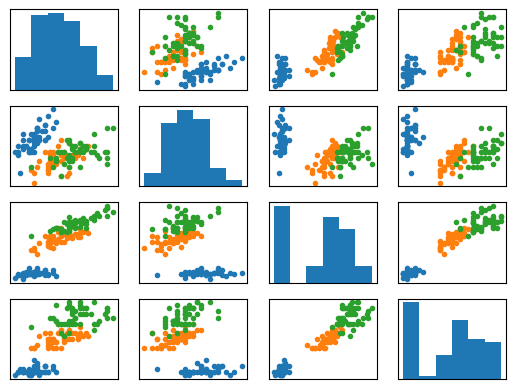

In [7]:
f, axes = plt.subplots(p, p)
for i in range(0, p):
    for j in range(0, p):
        if i == j:
            axes[i, i].hist(X[:, i], 6)
            axes[i, i].set_xticks([])
            axes[i, i].set_yticks([])
        else:
            for m in np.arange(1, k + 1):
                I = np.nonzero(y == m)[0]
                axes[i, j].plot(X[I, j], X[I, i], '.')
                axes[i, j].set_xticks([])
                axes[i, j].set_yticks([])
plt.show()

### Dimensionality reduction and PCA

In order to display the data in 2-D or 3-D, dimensionality reduction is needed.
The simplest method is the Principal Component Analysis (PCA), which performs an
orthogonal linear projection on the space spanned by the first eigenvectors of the
covariance matrix.

Compute the empirical mean
$$    m = \frac{1}{n} \sum_{i=1}^n x_i \in \mathbb{R}^p $$
and covariance
$$ C = \frac{1}{n} \sum_{i=1}^n (x_i-m) (x_i-m)^\top \in \mathbb{R}^{p \times p}. $$
Denoting $\tilde X = X - 1_n m^\top $, one has $C=\frac1n \tilde X^\top
\tilde X$.

Compute the empirical covariance matrix of the data. You may want to use `np.mean`.

In [9]:
def Cov(X):
    X_tilde = # your code here
    return np.dot(X_tilde.T, X_tilde) / X.shape[0]

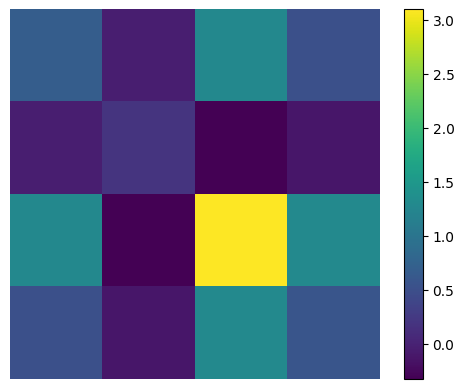

In [10]:
# display the covariance matrix
plt.imshow(Cov(X))
plt.colorbar()
plt.axis('off')
plt.show()

Compute the PCA ortho-basis using the SVD decomposition
$$ \tilde X = U \text{diag}(s) V  $$
where $U \in \mathbb{R}^{n \times n}$ and $V \in \mathbb{R}^{p \times p}$ are orthogonal matrices and the $s_i$ are in descending order.

In [578]:
U, D, V = np.linalg.svd(X - np.mean(X, axis=0))

Compute the features in the PCA basis, $z_i=V (x_i-m) $, stored in matrix
format as $Z=\tilde X V^\top$.

In [579]:
Z = (X - np.mean(X, axis=0)) @ V.T

We plot the singular values of the covariance, which correspond to the standard deviation of the data along the principal directions.

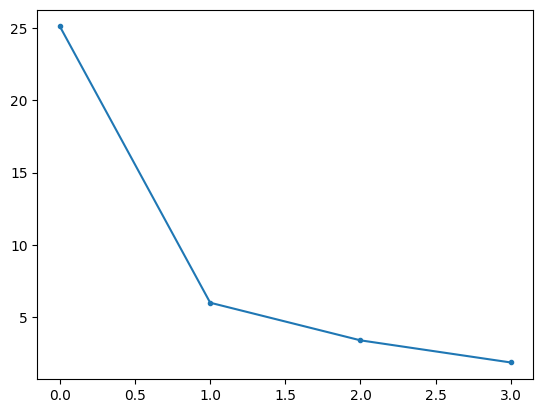

In [580]:
plt.plot(D, '.-')
plt.show()

Let us then do PCA in 2D and 3D.

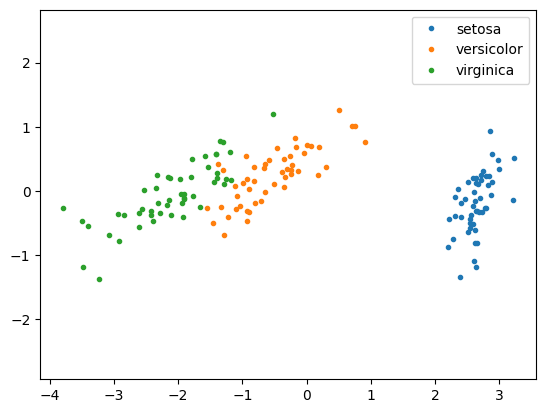

In [581]:
# in 2D
for i in range(1, k + 1):
    I = np.nonzero(y == i)[0]
    # your code here
plt.axis('tight') 
plt.axis('equal')
plt.legend()
plt.show()

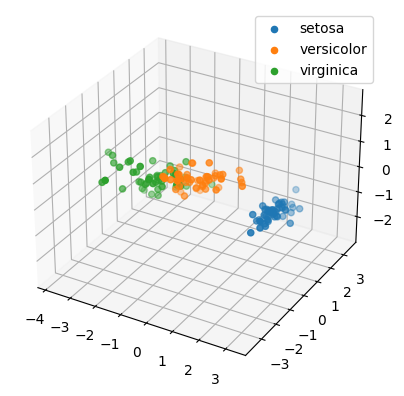

In [582]:
# in 3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(1, k + 1):
    I = np.where(y == i)
    # your code here
plt.axis('tight') 
plt.axis('equal')
plt.legend()
plt.show()

### Supervised learning: Nearest Neighbor Classification

One of the simplest methods for supervised classification is the Nearest
Neighbor method ($R$-NN), where $R$ is a parameter indexing the number of neighbors.
Tuning $R$ is important to cope with noise and obtain a smooth
decision boundary, and hence better generalization performance.

The predicted class for a point $x$ is the one (or one) which is the most
represented among the $R$ nearest neighbors of $x$ among the $(x_i)_i$.

Let us split the data into training and testing.

In [583]:
n0 = round(0.5 * n)
n1 = n - n0
X0 = X[0:n0, :]  # training set
y0 = y[0:n0]
X1 = X[n0:, :] # test set
y1 = y[n0:]

We will need an efficient way of computing pairwise distances between two sets of points.

In [584]:
# first option
def get_distances_1(X, Y):
    return np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2)

# second option
def get_distances(X, Y):
    pow_X = np.sum(X ** 2, axis=1)
    pow_Y = np.sum(Y ** 2, axis=1)
    dots = X @ Y.T
    return -2 * dots + pow_X[:, None] + pow_Y[None, :]

# third option
from sklearn.metrics.pairwise import pairwise_distances

In [585]:
n_test = 1000
d_test = 100
m_test = 300

X_test = np.random.randn(n_test, d_test)
Y_test = np.random.randn(m_test, d_test)

In [586]:
print(np.allclose(get_distances(X_test, Y_test), get_distances_1(X_test, Y_test)))
print(np.allclose(get_distances(X_test, Y_test), pairwise_distances(X_test, Y_test) ** 2))

True
True


In [ ]:
%timeit get_distances_1(X_test, Y_test)
%timeit get_distances(X_test, Y_test)
%timeit pairwise_distances(X_test, Y_test)

Let us start by classifying one point.

In [587]:
x = X1[0, :]  # could be any point, we take the first one from the test set

def DistPoint(X, x):
    return get_distances(X, x.reshape(1, -1))  # x has to be reshaped to a row vector

D = DistPoint(X0, x)

We sort the distances and generate the list of sorted classes $ y_\sigma = (y_{\sigma(i)})_i$ where the indexing $\sigma$ is a permutation of $\{1, \dots, n_0\}$ such that
$$ \|x-x_{\sigma(1)}\| \leq \|x-x_{\sigma(2)}\| \leq \ldots \leq \|x-x_{\sigma(n_0)}\|. $$

In [588]:
I = np.argsort(D.flatten())
y_sigma = y[I]
print(y_sigma)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1]


For a given $R$, one can compute the histogram of class apparition
$$ h_\ell \coloneqq \sharp\{ i : y_i = \ell~~ \text{and}~~ \sigma(i) \in \{1,\ldots,R\} \} / R
.$$
The decision class for $x$ is then the maximum of the histogram
$$ c(x) \coloneqq \text{argmax}_{\ell} h_\ell $$

In [589]:
R = 5
y_R = y_sigma[:R]

def myhist(y_R):
    h = np.zeros(k)
    for i in range(k):
        h[i] = # your code here
    return h

h = myhist(y_R) / R
c = np.argmax(h) + 1
print( 'c(x)=' + str(c) + ', true class=' + str(int(y1[0])) )

c(x)=3, true class=3


Display the histogram $(h_\ell)_\ell$ of repartition of class indexes as $R$ grows.

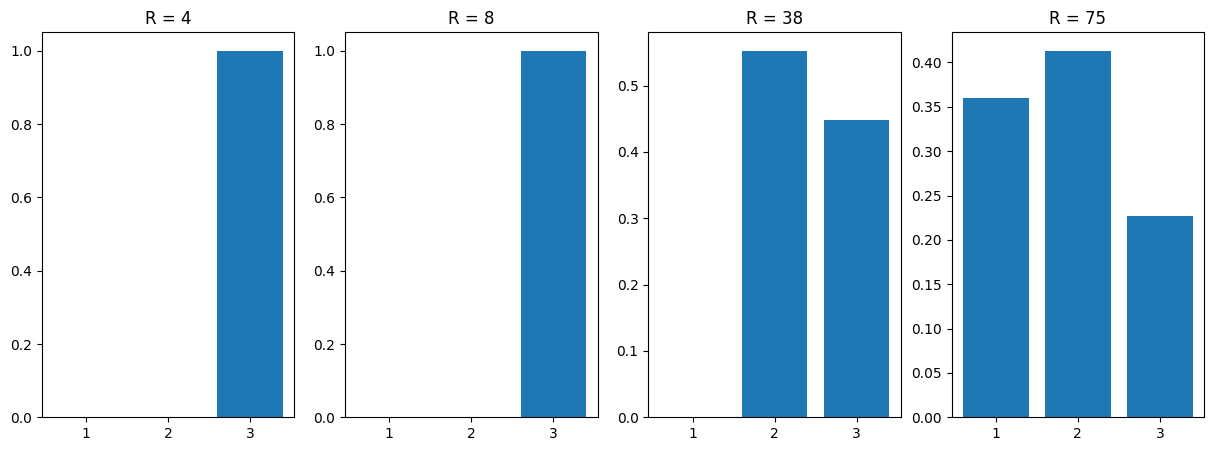

In [590]:
R_list = (np.array([.05, .1, .5, 1.]) * n0).round()

f, axes = plt.subplots(1, R_list.size, figsize=(15, 5))
for i in range(R_list.size):
    R = int(R_list[i])
    h = myhist(y_sigma[:R]) / R
    axes[i].bar(np.arange(1, k + 1), h)
    axes[i].set_title(f'R = {R}')
plt.show()

**Exercise:** Perform the nearest neighbor classification for all the points in the test set, and for a varying $R$.
Show how the classification score $S$ (fraction of correctly classified points)
evolves with $R$.

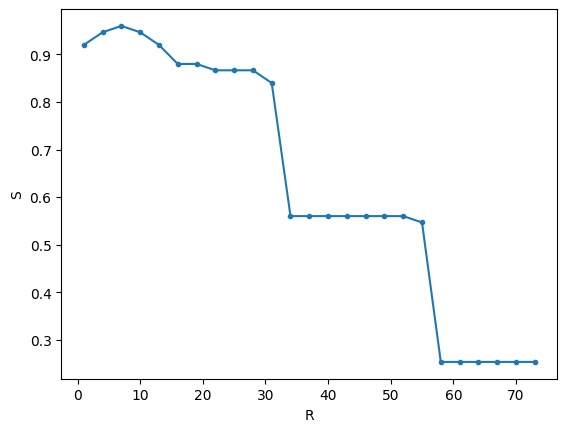

In [591]:
R_list = # your code here

def classify(x, X0, y0, R):
    D = DistPoint(X0, x)
    I = np.argsort(D.flatten())
    y_sigma = y0[I]
    y_R = y_sigma[:R]
    h = myhist(y_R)
    return np.argmax(h) + 1

S_list = np.zeros(R_list.size)
# your code here

plt.plot(R_list, S_list, '.-')
plt.xlabel('R')
plt.ylabel('S')
plt.show()

**Exercise:** Display, as a function of the position in the 2D PCA space, the class output by
the $R$-NN method when applied in 2D. You can use the function `plt.contourf`.

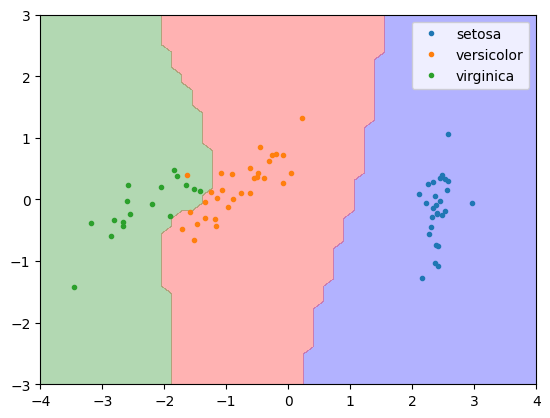

In [592]:
# your code here


### Unsupervised learning: $k$-means

In an unsupervised setting, the class information $y$ is not
available. The basic problem is then to recover class information from
the knowledge of $x$ only. The most basic algorithm is the $k$-means clustering, which tries to recover the class index $y_i=\ell$ from the distance $ \|x_i-c_\ell\| $
between the feature point $x_i$ and the class centroid $c_\ell$
(which is unknown).

It does so by minimizing in $(c_\ell)_\ell$ the following non-convex energy
  $$ \sum_i \min_{\ell}\|x_i-c_\ell\|^2   .$$


We first initialize the class centroids $ (c_\ell)_\ell $ at random among the points.
They are stored as the rows of a matrix $ C \in \mathbb{R}^{k \times p} $.

In [593]:
I = np.random.permutation(n)
I = I[0:k]
C = X[I, :]

The $k$-means algorithm iterates two distinct steps. First, determining the class of
each point using the distance to the centroids
  $$ \forall i \in \{1,\dots,n\}, ~~~~~~ \bar y_i \leftarrow
          \text{argmin}_{\ell} \|x_i-c_\ell\|. $$

In [594]:
D = get_distances(X, C)
ybar = np.argmin(D, axis=1)

The second step is to update the centroids'
position to be the mean of the points inside each class
 $$ \forall \ell \in \{1,\ldots,k\}, ~~~~~ c_\ell \leftarrow
      \frac{ \sum_{\{i:y_i=\ell\}} x_i }{ \sharp \{i:y_i=\ell\} }. $$

In [595]:
for l in range(k):
    C[l, :] = np.mean(X[ybar == l, :], axis=0)

Let us display the current centroids and classes.

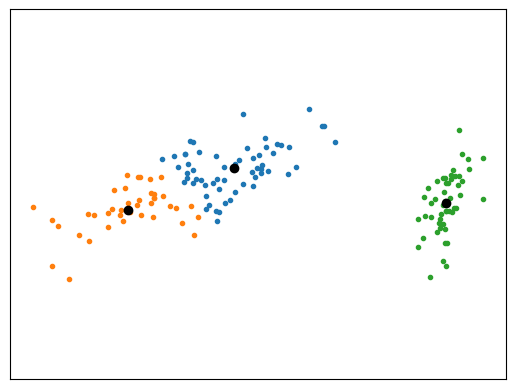

In [596]:
U, D, V = np.linalg.svd(X - np.mean(X, axis=0))
Z = (X - np.mean(X, axis=0)) @ V.T

def display_centroids(ax, C, ybar, X, V, Z):
    CV = (C - np.mean(X, axis=0)) @ V.T

    for i in range(k):
        I = np.nonzero(ybar == i)[0]
        ax.plot(Z[I, 0], Z[I, 1], '.')

    for i in np.arange(0, k):
        ax.plot(CV[i, 0], CV[i, 1], 'ok')

    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

f, ax = plt.subplots()
display_centroids(ax, C, ybar, X, V, Z)
plt.show()

**Exercise:** Perform several steps of the $k$-means algorithm and plot the evolution of the centroids. Then, inside each predicted class $\bar y_i$, plot the histogram of the true classes.

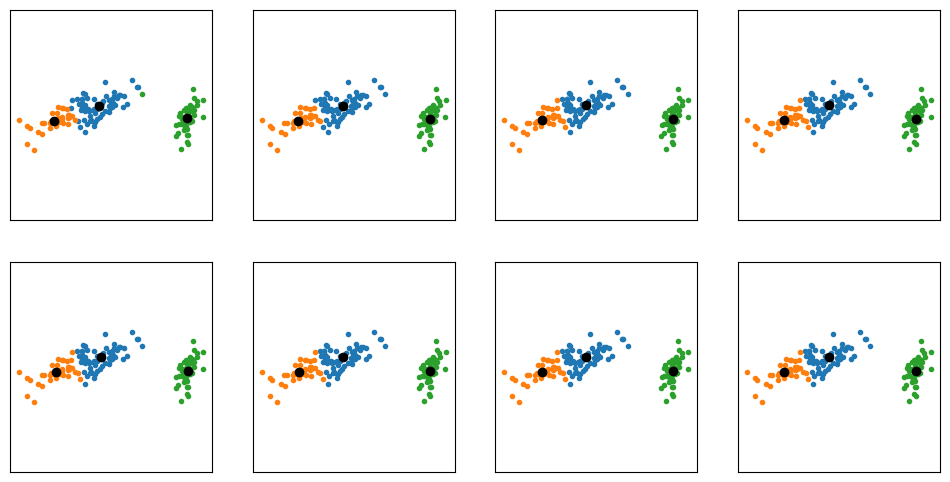

In [597]:
n_steps = 8

# init
I = np.random.permutation(n)
I = I[0:k]
C = X[I, :]

f, axes = plt.subplots(2, n_steps // 2, figsize=(12, 6))
for j in range(n_steps):
    # your code here
    display_centroids(axes[j // 4, j % 4], C, ybar, X, V, Z)
plt.show()

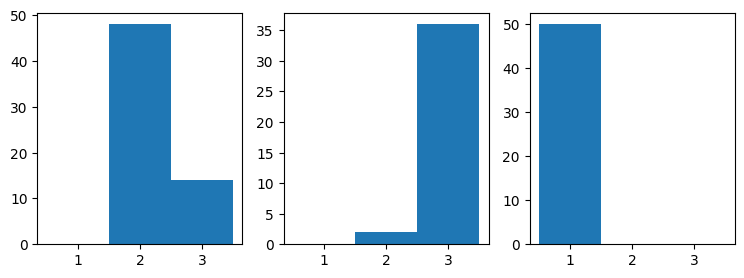

In [598]:
# your code here

**Question:** Does the $k$-means algorithm always converge to the optimal solution?

### Improving the init of $k$-means with $k$-means++

[$k$-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) changes the initialization of $k$-means so that the initial centroids are more spread out. This guarantees that the solution at convergence cannot be arbitrarily bad with respect to the optimal solution (see the paper $k$-means++: The Advantage of Careful Seeding by Arthur and Vassilvitskii). Code the initialization of $k$-means++.

In [599]:
# your code here

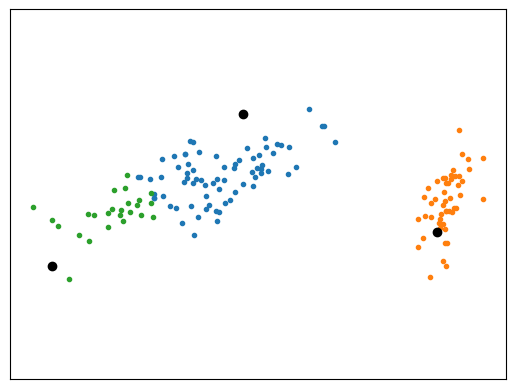

In [600]:
D = get_distances(X, C)
ybar = np.argmin(D, axis=1)

f, ax = plt.subplots()
display_centroids(ax, C, ybar, X, V, Z)
plt.show()